<a href="https://colab.research.google.com/github/yuliastoliaruk/Computer_Vision_NaUKMA/blob/main/intel_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.utils import make_grid
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

## 1. Data Preparation (Practice 1)

### Data Augmentation

In [ ]:
transform_train_data = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
data_path = "/content/drive/MyDrive/Intel_Image_Classification/data"

data_train = torchvision.datasets.ImageFolder(root=f"{data_path}/seg_train", transform=transform_train_data)
data_test = torchvision.datasets.ImageFolder(root=f"{data_path}/seg_test", transform=transform_test_data)

In [ ]:
print("Classes:", data_train.classes)

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


### Split into training and validation sets.

In [ ]:
def images_per_class(data, dataset=None):
    if dataset is None:
        labels = data.targets
    else:
        labels = [data.targets[i] for i in dataset.indices]

    class_counts = Counter(labels)
    class_names = data.classes

    print('Number of images in each class:')
    for class_id, count in class_counts.items():
        print(f"{class_names[class_id]}: {count} images")

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, [class_counts[i] for i in range(len(class_names))], color='purple')

    plt.xlabel('Classes')
    plt.ylabel('Number of Images')

    return plt

Number of images in each class:
buildings: 437 images
forest: 474 images
glacier: 553 images
mountain: 525 images
sea: 510 images
street: 501 images


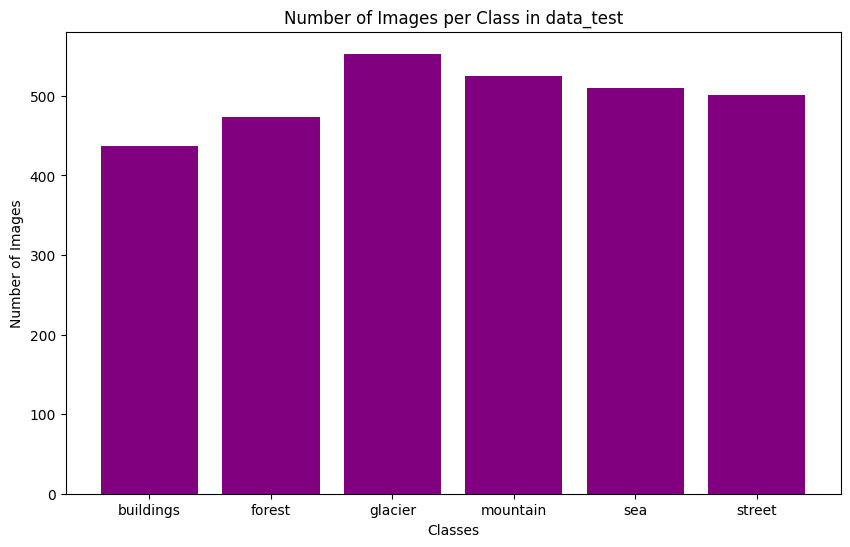

In [ ]:
plt = images_per_class(data_test)
plt.title('Number of Images per Class in data_test')
plt.show()

Number of images in each class:
buildings: 2191 images
forest: 2271 images
glacier: 2404 images
mountain: 2512 images
sea: 2274 images
street: 2382 images


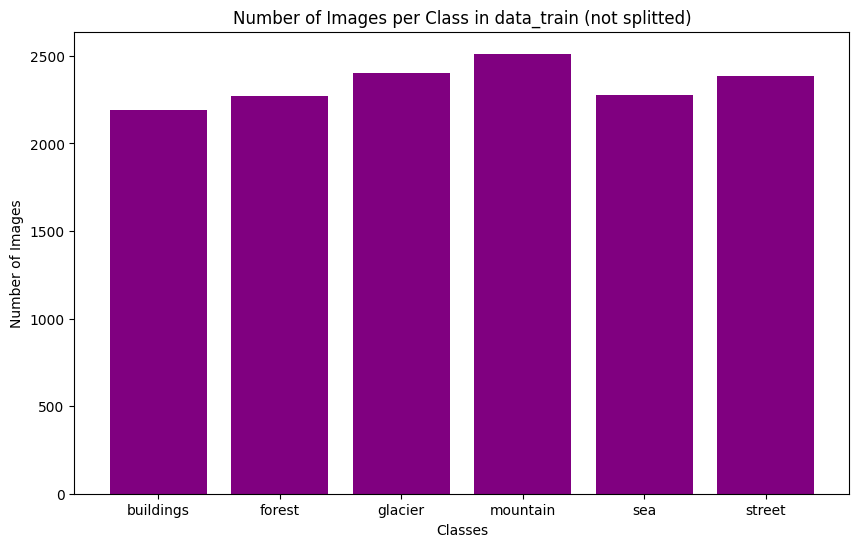

In [ ]:
plt = images_per_class(data_train)
plt.title('Number of Images per Class in data_train (not splitted)')
plt.show()

As we can see from the bar plot, the training dataset is imbalanced. To balance the data, I will take 1900 images from each class for `train_ds`, and the rest will go to `val_ds`

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

labels = np.array(data_train.targets)
num_classes = len(set(labels))
samples_per_class = 1900

class_indices = defaultdict(list)

for idx, label in enumerate(labels):
    class_indices[label].append(idx)

train_indices = []
val_indices = []

for class_id, indices in class_indices.items():
    np.random.seed(random_seed)
    np.random.shuffle(indices)

    train_class_indices = indices[:samples_per_class]
    val_class_indices = indices[samples_per_class:]

    train_indices.extend(train_class_indices)
    val_indices.extend(val_class_indices)

train_ds = Subset(data_train, train_indices)
val_ds = Subset(data_train, val_indices)

In [ ]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(data_test, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Number of images in each class:
buildings: 1900 images
forest: 1900 images
glacier: 1900 images
mountain: 1900 images
sea: 1900 images
street: 1900 images


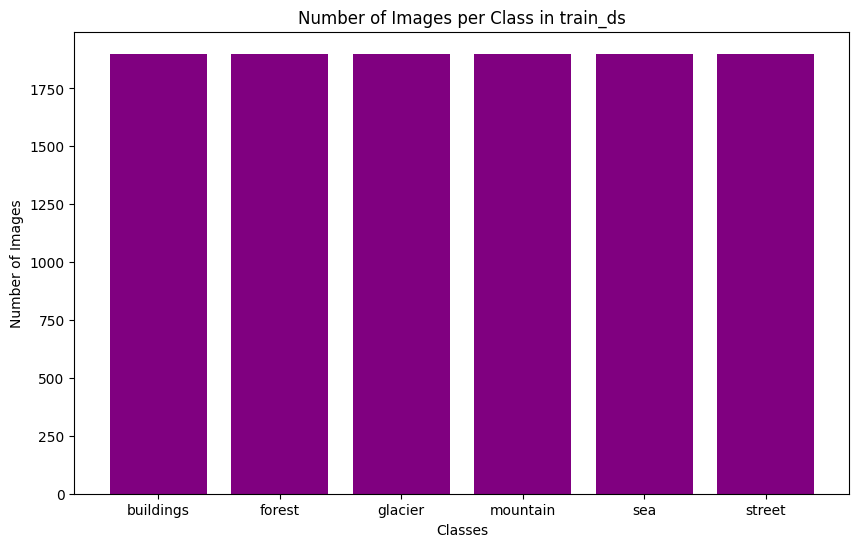

In [ ]:
plt = images_per_class(data_train, train_ds)
plt.title('Number of Images per Class in train_ds')
plt.show()

Number of images in each class:
buildings: 291 images
forest: 371 images
glacier: 504 images
mountain: 612 images
sea: 374 images
street: 482 images


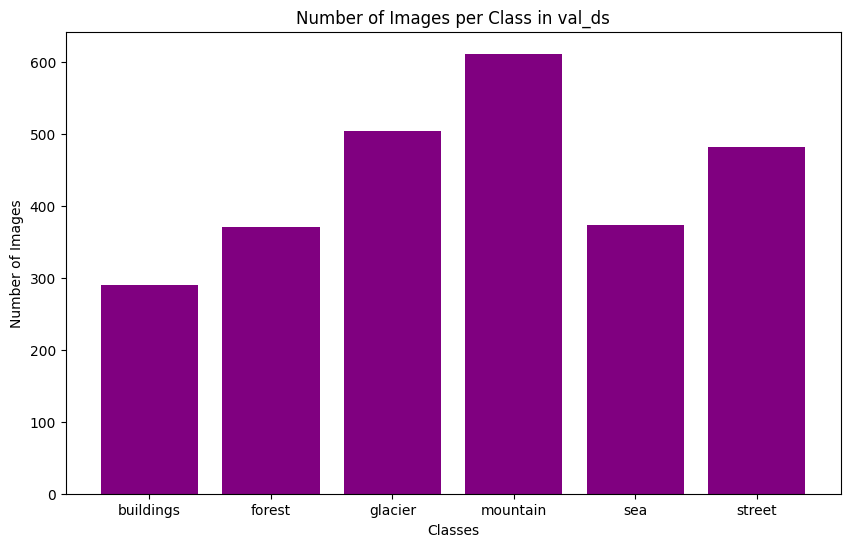

In [ ]:
plt = images_per_class(data_train, val_ds)
plt.title('Number of Images per Class in val_ds')
plt.show()

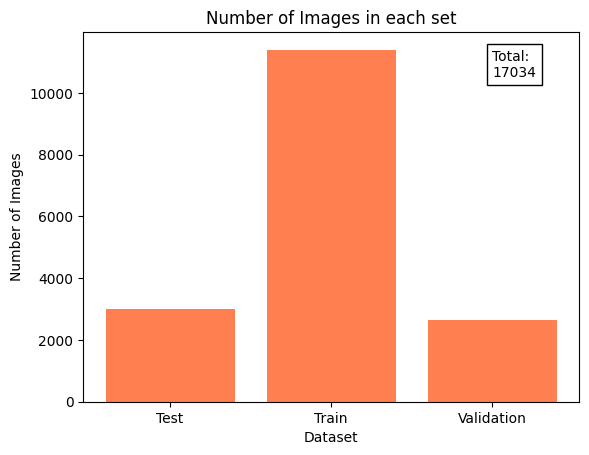

In [ ]:
plt.bar(['Test', 'Train', 'Validation'], [len(data_test), len(train_ds), len(val_ds)], color='coral')
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Number of Images in each set')
plt.text(2, len(data_train)*0.75, f"Total:\n{len(data_test) + len(data_train)}", bbox=dict(facecolor="white", edgecolor="black"))
plt.show()

### Denormalization

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy() if isinstance(img, torch.Tensor) else img
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


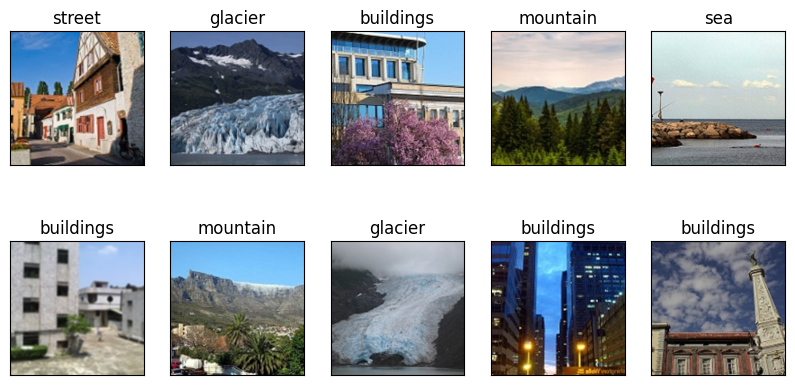

In [ ]:
classes = data_train.classes

data_iter = iter(train_dl)
images, labels = next(data_iter)
images = images.to(device)
labels = labels.to(device)

n = 10
fig = plt.figure(figsize=(n, 5))

for idx in np.arange(n):
    ax = fig.add_subplot(2, int(n/2), idx + 1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title(str(classes[labels[idx].item()]),
        color=("black")
    )

plt.show()

# 2. Basic neural network model (Practice 2)

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def train(model, epochs, lr, loss_function):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    train_accuracies = []
    train_f1s = []
    train_precisions = []
    train_recalls = []

    val_losses = []
    val_accuracies = []
    val_f1s = []
    val_precisions = []
    val_recalls = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        for images, labels in train_dl:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_dl)
        train_acc = accuracy_score(all_labels, all_preds) * 100
        train_f1 = f1_score(all_labels, all_preds, average='macro') * 100
        train_precision = precision_score(all_labels, all_preds, average='macro') * 100
        train_recall = recall_score(all_labels, all_preds, average='macro') * 100

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_f1s.append(train_f1)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)


        model.eval()
        val_loss = 0.0
        all_val_preds, all_val_labels = [], []

        with torch.no_grad():
            for images, labels in val_dl:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_function(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_dl)
        val_acc = accuracy_score(all_val_labels, all_val_preds) * 100
        val_f1 = f1_score(all_val_labels, all_val_preds, average='macro') * 100
        val_precision = precision_score(all_val_labels, all_val_preds, average='macro') * 100
        val_recall = recall_score(all_val_labels, all_val_preds, average='macro') * 100

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, "
              f"F1-score: {train_f1:.2f}, Precision: {train_precision:.2f}, Recall: {train_recall:.2f} | "
              f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.2f}%, "
              f"F1-score: {val_f1:.2f}, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}")

    train_metrics = {
        'losses': train_losses,
        'accuracies': train_accuracies,
        'f1_scores': train_f1s,
        'precisions': train_precisions,
        'recalls': train_recalls
    }

    val_metrics = {
        'losses': val_losses,
        'accuracies': val_accuracies,
        'f1_scores': val_f1s,
        'precisions': val_precisions,
        'recalls': val_recalls
    }

    return train_metrics, val_metrics

In [ ]:
cnn_v0 = CNNModel()
lr=0.001
loss_function = nn.CrossEntropyLoss()
epochs = 20

In [ ]:
train_metrics, val_metrics = train(cnn_v0, epochs, lr, loss_function)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/20 - Loss: 1.0462, Accuracy: 60.39%, F1-score: 60.21, Precision: 60.11, Recall: 60.39 | Validation loss: 0.8611, Validation accuracy: 66.89%, F1-score: 66.55, Precision: 69.38, Recall: 65.97


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/20 - Loss: 0.7223, Accuracy: 73.72%, F1-score: 73.73, Precision: 73.74, Recall: 73.72 | Validation loss: 0.6738, Validation accuracy: 75.36%, F1-score: 75.33, Precision: 76.92, Recall: 76.72


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/20 - Loss: 0.5810, Accuracy: 78.45%, F1-score: 78.44, Precision: 78.44, Recall: 78.45 | Validation loss: 0.5748, Validation accuracy: 79.01%, F1-score: 78.99, Precision: 78.92, Recall: 79.89


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/20 - Loss: 0.5032, Accuracy: 81.81%, F1-score: 81.80, Precision: 81.80, Recall: 81.81 | Validation loss: 0.4926, Validation accuracy: 82.19%, F1-score: 82.15, Precision: 82.32, Recall: 82.03


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/20 - Loss: 0.4463, Accuracy: 83.86%, F1-score: 83.86, Precision: 83.87, Recall: 83.86 | Validation loss: 0.5122, Validation accuracy: 81.74%, F1-score: 81.89, Precision: 82.07, Recall: 82.63


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/20 - Loss: 0.4024, Accuracy: 85.39%, F1-score: 85.38, Precision: 85.39, Recall: 85.39 | Validation loss: 0.4974, Validation accuracy: 82.27%, F1-score: 82.14, Precision: 83.02, Recall: 82.26


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/20 - Loss: 0.3723, Accuracy: 86.41%, F1-score: 86.40, Precision: 86.40, Recall: 86.41 | Validation loss: 0.6265, Validation accuracy: 78.59%, F1-score: 78.75, Precision: 80.22, Recall: 80.33


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/20 - Loss: 0.3460, Accuracy: 87.48%, F1-score: 87.48, Precision: 87.48, Recall: 87.48 | Validation loss: 0.4822, Validation accuracy: 83.26%, F1-score: 83.14, Precision: 83.69, Recall: 83.32


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/20 - Loss: 0.3142, Accuracy: 88.36%, F1-score: 88.35, Precision: 88.34, Recall: 88.36 | Validation loss: 0.4689, Validation accuracy: 83.86%, F1-score: 83.86, Precision: 84.21, Recall: 83.65


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/20 - Loss: 0.2917, Accuracy: 89.40%, F1-score: 89.39, Precision: 89.39, Recall: 89.40 | Validation loss: 0.4650, Validation accuracy: 84.02%, F1-score: 84.04, Precision: 84.51, Recall: 84.61


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11/20 - Loss: 0.2645, Accuracy: 90.54%, F1-score: 90.53, Precision: 90.54, Recall: 90.54 | Validation loss: 0.5051, Validation accuracy: 83.37%, F1-score: 83.56, Precision: 83.31, Recall: 84.72


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12/20 - Loss: 0.2348, Accuracy: 91.71%, F1-score: 91.71, Precision: 91.70, Recall: 91.71 | Validation loss: 0.4843, Validation accuracy: 83.56%, F1-score: 83.61, Precision: 83.41, Recall: 83.92


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13/20 - Loss: 0.2292, Accuracy: 91.65%, F1-score: 91.65, Precision: 91.65, Recall: 91.65 | Validation loss: 0.4779, Validation accuracy: 84.47%, F1-score: 84.60, Precision: 84.73, Recall: 84.77


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14/20 - Loss: 0.2247, Accuracy: 91.89%, F1-score: 91.88, Precision: 91.89, Recall: 91.89 | Validation loss: 0.5260, Validation accuracy: 82.76%, F1-score: 82.86, Precision: 82.50, Recall: 83.57


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15/20 - Loss: 0.1967, Accuracy: 92.82%, F1-score: 92.83, Precision: 92.83, Recall: 92.82 | Validation loss: 0.5795, Validation accuracy: 81.51%, F1-score: 81.73, Precision: 81.76, Recall: 82.24


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16/20 - Loss: 0.1875, Accuracy: 93.32%, F1-score: 93.32, Precision: 93.32, Recall: 93.32 | Validation loss: 0.5019, Validation accuracy: 84.13%, F1-score: 84.35, Precision: 84.41, Recall: 84.66


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17/20 - Loss: 0.1877, Accuracy: 93.69%, F1-score: 93.69, Precision: 93.70, Recall: 93.69 | Validation loss: 0.5522, Validation accuracy: 83.79%, F1-score: 84.04, Precision: 83.81, Recall: 84.86


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18/20 - Loss: 0.1636, Accuracy: 94.46%, F1-score: 94.47, Precision: 94.47, Recall: 94.46 | Validation loss: 0.5009, Validation accuracy: 84.02%, F1-score: 84.04, Precision: 84.46, Recall: 84.05


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19/20 - Loss: 0.1635, Accuracy: 94.49%, F1-score: 94.49, Precision: 94.50, Recall: 94.49 | Validation loss: 0.5831, Validation accuracy: 84.32%, F1-score: 84.50, Precision: 84.29, Recall: 85.57


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20/20 - Loss: 0.1533, Accuracy: 94.67%, F1-score: 94.67, Precision: 94.67, Recall: 94.67 | Validation loss: 0.6192, Validation accuracy: 82.99%, F1-score: 83.25, Precision: 83.31, Recall: 84.20


In [ ]:
torch.save(cnn_v0.state_dict(), "cnn_v0.pth")

In [ ]:
def plot_metrics(train_metrics, val_metrics):


    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    plt.plot(train_metrics['losses'], label='Train Loss')
    plt.plot(val_metrics['losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(train_metrics['accuracies'], label='Train Accuracy')
    plt.plot(val_metrics['accuracies'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(train_metrics['f1_scores'], label='Train F1-score')
    plt.plot(val_metrics['f1_scores'], label='Validation F1-score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.title('F1-score Curve')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(train_metrics['precisions'], label='Train Precision')
    plt.plot(val_metrics['precisions'], label='Validation Precision')
    plt.plot(train_metrics['recalls'], label='Train Recall', linestyle='dashed')
    plt.plot(val_metrics['recalls'], label='Validation Recall', linestyle='dashed')
    plt.xlabel('Epoch')
    plt.ylabel('Precision / Recall')
    plt.title('Precision & Recall Curve')
    plt.legend()

    plt.tight_layout()
    return plt

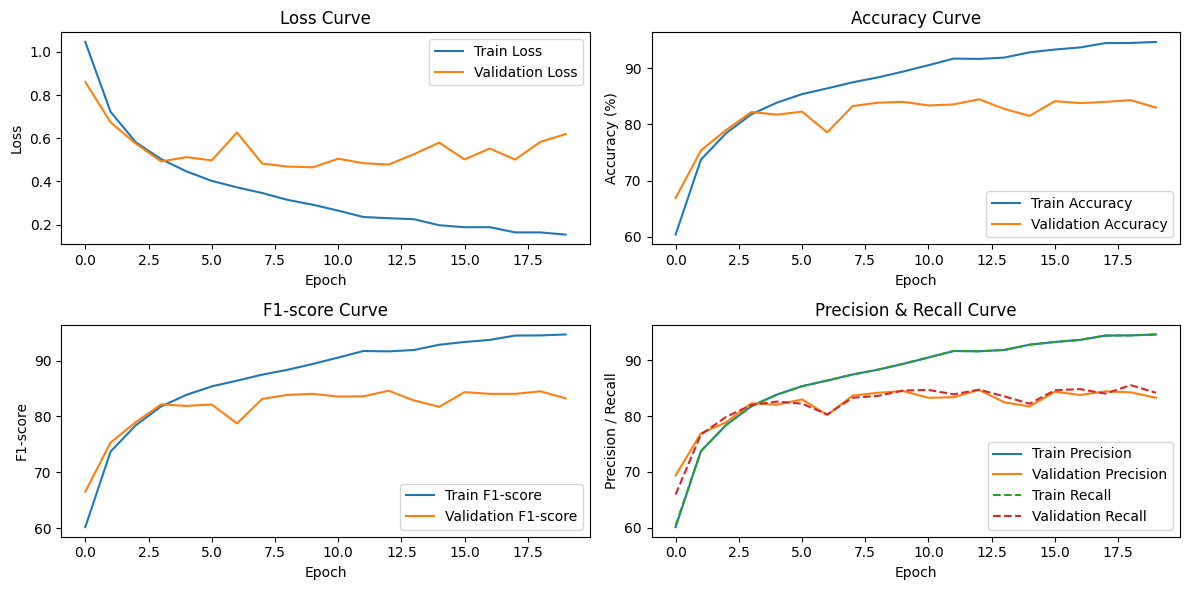

In [ ]:
plot_metrics(train_metrics, val_metrics).show()